In [1]:
import geopandas as gpd
import pandas as pd
import pyproj
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt
import contextily as cx


pyproj.datadir.set_data_dir('/usr/local/anaconda3/envs/info615/share/proj')


/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
hex_gdf = gpd.read_file('processed_data/complaints_per_10000_people_zero_and_low_pop_outliers_lt10_dropped.geojson')
hex_gdf = hex_gdf.set_crs(epsg=2263, allow_override= True)

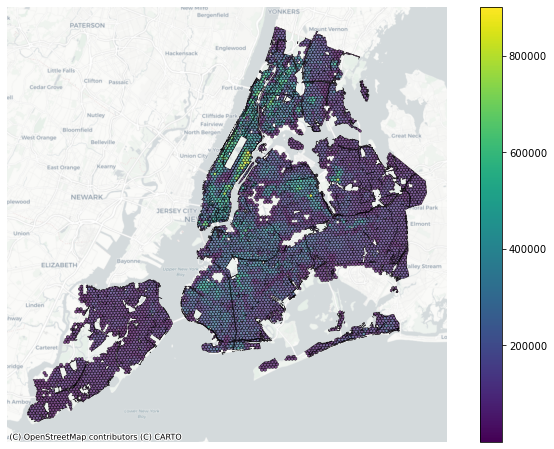

In [3]:
ax = hex_gdf.to_crs(epsg=3857).plot(column = '2020PopEstimate', alpha = .7, edgecolor='black', linewidth = .5, figsize=(12, 8), legend = True)
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.axis('off');

In [4]:
#Generate weights
w_with_islands = weights.Queen.from_dataframe(hex_gdf)

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary)
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/_contW_lists.py:26: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy))
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 10 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In [47]:
wKNN = weights.KNN.from_dataframe(hex_gdf, k=6)

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/util.py:1028: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in iterable])
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 7 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In [48]:
w = weights.attach_islands(w_with_islands, wKNN)

There are no disconnected observations (no islands)!


In [49]:
#Row standardize
w.transform = 'R'

### Run local Moran's I on normalized column

In [50]:
local_moran = esda.moran.Moran_Local(hex_gdf['num_311_complaints_norm'], w)

In [51]:
hex_gdf['local_moran_Is'] = local_moran.Is
hex_gdf['local_moran_p_value'] = local_moran.p_sim
hex_gdf['local_moran_quadrant'] = local_moran.q

In [52]:
alpha = .05
hotspots = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
doughnuts = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
diamonds = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

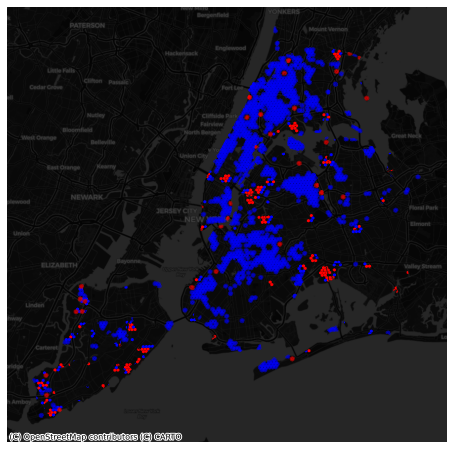

In [54]:
ax = hex_gdf.to_crs(epsg=3857).plot(facecolor='none', alpha=0, figsize = (12,8))
hotspots.to_crs(epsg=3857).plot(color='red', ax=ax, label='Hot Spot')
coldspots.to_crs(epsg=3857).plot(color='blue', ax=ax, label='Cold Spot')
doughnuts.to_crs(epsg=3857).plot(color='blue', alpha=.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.to_crs(epsg=3857).plot(color='red', alpha=.5, edgecolor='red', linewidth=2, ax=ax, label='Doughnuts')
cx.add_basemap(ax,source=cx.providers.CartoDB.DarkMatter)
ax.axis('off');


### Run local Moran's I on UNnormalized column

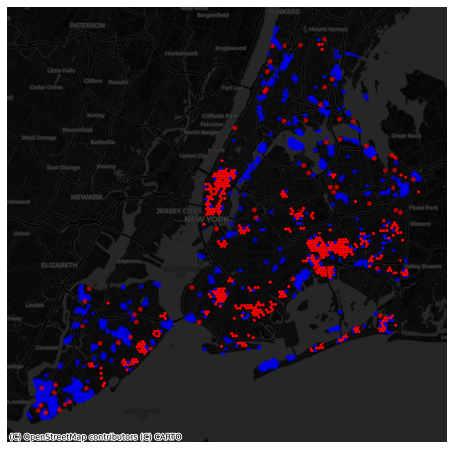

In [55]:
local_moran = esda.moran.Moran_Local(hex_gdf['num_311_complaints'], w)

hex_gdf['local_moran_Is'] = local_moran.Is
hex_gdf['local_moran_p_value'] = local_moran.p_sim
hex_gdf['local_moran_quadrant'] = local_moran.q

alpha = .05
hotspots = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
doughnuts = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
diamonds = hex_gdf.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

ax = hex_gdf.to_crs(epsg=3857).plot(facecolor='none', alpha=0, figsize = (12,8))
hotspots.to_crs(epsg=3857).plot(color='red', ax=ax, label='Hot Spot')
coldspots.to_crs(epsg=3857).plot(color='blue', ax=ax, label='Cold Spot')
doughnuts.to_crs(epsg=3857).plot(color='blue', alpha=.5, edgecolor='blue', linewidth=2, ax=ax, label='Doughnuts')
diamonds.to_crs(epsg=3857).plot(color='red', alpha=.5, edgecolor='red', linewidth=2, ax=ax, label='Doughnuts')
cx.add_basemap(ax,source=cx.providers.CartoDB.DarkMatter)
ax.axis('off');

In [ ]:
#Compare this map to population map - you see that highly populated areas do jump out

In [ ]:
#Use the color palette that I developed for previous final project